=== Problem: 1D Constant-Velocity ===
F=
 [[1.  0.1]
 [0.  1. ]]
H=
 [[1. 0.]]
diag(Q_true) = [0.01 0.01]  q_scale= 0.1
diag(R_true) = [1.]  r_scale= 1.0
gamma_Q, gamma_R = 10.0 5.0

Epoch 01 | Train MSE (KNet): 0.619193 | Test MSE (KNet): 0.285712 | Test MSE (KF assumed): 0.285900
Epoch 02 | Train MSE (KNet): 0.282313 | Test MSE (KNet): 0.270147 | Test MSE (KF assumed): 0.285900
Epoch 03 | Train MSE (KNet): 0.272949 | Test MSE (KNet): 0.266852 | Test MSE (KF assumed): 0.285900
Epoch 04 | Train MSE (KNet): 0.270116 | Test MSE (KNet): 0.265048 | Test MSE (KF assumed): 0.285900
Epoch 05 | Train MSE (KNet): 0.266100 | Test MSE (KNet): 0.260078 | Test MSE (KF assumed): 0.285900
Epoch 06 | Train MSE (KNet): 0.261497 | Test MSE (KNet): 0.258411 | Test MSE (KF assumed): 0.285900
Epoch 07 | Train MSE (KNet): 0.260179 | Test MSE (KNet): 0.256554 | Test MSE (KF assumed): 0.285900
Epoch 08 | Train MSE (KNet): 0.261364 | Test MSE (KNet): 0.255831 | Test MSE (KF assumed): 0.285900
Epoch 09 | Train 

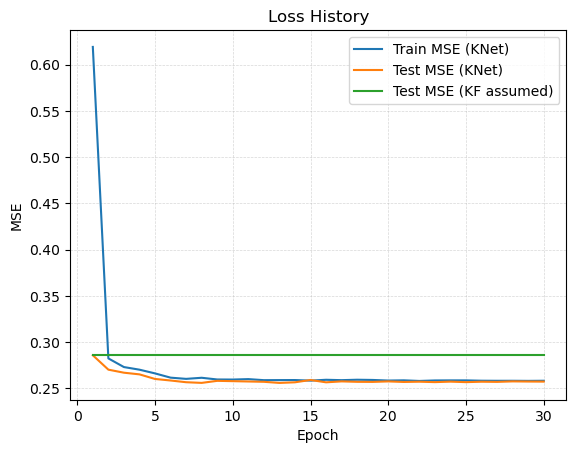


===== Final Comparison on Test Set =====
KNet (Revach-style)          MSE: 2.572034e-01 | RMSE: 5.071522e-01
Kalman Filter (assumed Q/R)  MSE: 2.858995e-01 | RMSE: 5.346958e-01


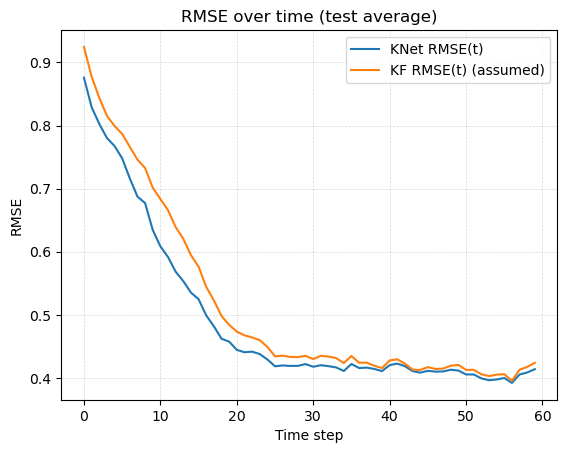

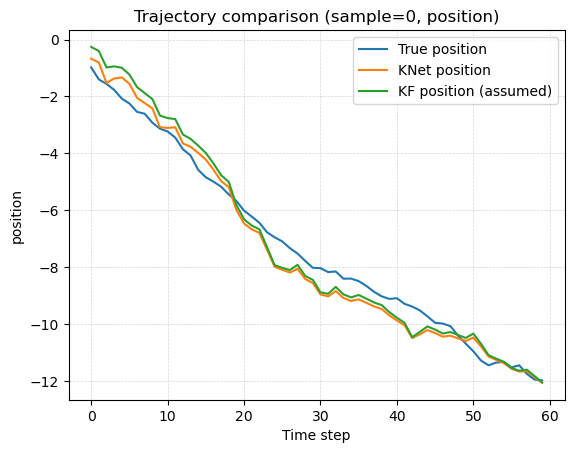

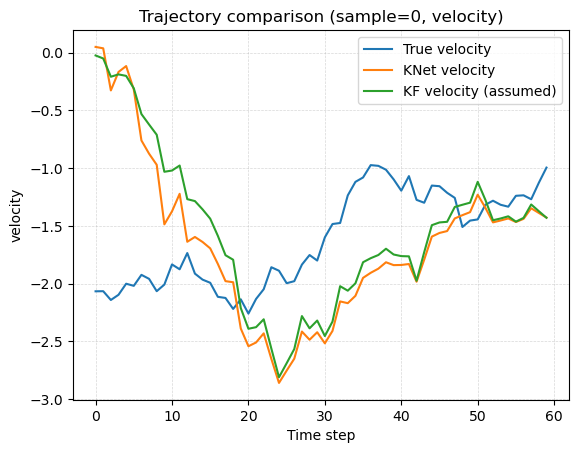

In [1]:
"""
Revach-style KalmanNet (KNet) for 1D Constant-Velocity model (pos, vel), measurement=pos.

Key differences vs simplified gain-RNN:
- Gain network input uses multiple normalized features (innovation, innovation-delta, y-delta,
  model-driven x-delta, posterior x-delta), as commonly used in Revach-style public KNet code.
- Kalman Filter baseline uses Joseph-form covariance update and solve() for numerical stability.

Data generation uses TRUE (Q_true, R_true).
Baseline KF assumes larger covariances (Q_assumed, R_assumed).
"""

import math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Dict, List


# -------------------------
# Utils
# -------------------------
def set_seed(seed: int = 0) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def l2_normalize(x: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    """Batch-wise L2 normalization along last dim."""
    n = torch.norm(x, dim=-1, keepdim=True)
    return x / (n + eps)


def sample_linear_sequences(
    num_seq: int,
    T: int,
    F: torch.Tensor,
    H: torch.Tensor,
    Q: torch.Tensor,
    R: torch.Tensor,
    x0_cov: float = 1.0,
    device: str = "cpu",
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    x_{t+1} = F x_t + w_t,   w_t ~ N(0,Q)
    y_t     = H x_t + v_t,   v_t ~ N(0,R)

    Returns:
      x: [N,T,n], y: [N,T,m]
    """
    n = F.shape[0]
    m = H.shape[0]

    LQ = torch.linalg.cholesky(Q)
    LR = torch.linalg.cholesky(R)

    x = torch.zeros(num_seq, T, n, device=device)
    y = torch.zeros(num_seq, T, m, device=device)

    x[:, 0, :] = torch.randn(num_seq, n, device=device) * math.sqrt(x0_cov)

    for t in range(T):
        v = torch.randn(num_seq, m, device=device) @ LR.T
        y[:, t, :] = x[:, t, :] @ H.T + v

        if t < T - 1:
            w = torch.randn(num_seq, n, device=device) @ LQ.T
            x[:, t + 1, :] = x[:, t, :] @ F.T + w

    return x, y


class SeqDataset(torch.utils.data.Dataset):
    def __init__(self, x: torch.Tensor, y: torch.Tensor):
        self.x = x
        self.y = y

    def __len__(self) -> int:
        return self.x.shape[0]

    def __getitem__(self, idx: int):
        return self.x[idx], self.y[idx]


# -------------------------
# Stable Kalman Filter (Joseph form, solve)
# -------------------------
@torch.no_grad()
def batch_kalman_filter(
    y: torch.Tensor,   # [B,T,m]
    F: torch.Tensor,
    H: torch.Tensor,
    Q: torch.Tensor,
    R: torch.Tensor,
    x0: Optional[torch.Tensor] = None,
    P0: Optional[torch.Tensor] = None,
) -> torch.Tensor:
    """
    Returns xhat: [B,T,n]
    """
    device = y.device
    B, T, _ = y.shape
    n = F.shape[0]
    m = H.shape[0]

    x_hat = torch.zeros(B, n, device=device) if x0 is None else x0.clone()
    P = (
        torch.eye(n, device=device).unsqueeze(0).expand(B, -1, -1).clone()
        if P0 is None
        else P0.clone()
    )
    I = torch.eye(n, device=device).unsqueeze(0).expand(B, -1, -1)
    H_b = H.unsqueeze(0).expand(B, -1, -1)          # [B,m,n]
    R_b = R.unsqueeze(0).expand(B, -1, -1)          # [B,m,m]
    F_b = F.unsqueeze(0).expand(B, -1, -1)          # [B,n,n]

    xhats = []
    for t in range(T):
        # Predict
        x_pred = x_hat @ F.T
        P_pred = F_b @ P @ F_b.transpose(1, 2) + Q.unsqueeze(0)

        # Innovation
        y_pred = x_pred @ H.T
        innov = y[:, t, :] - y_pred  # [B,m]

        # S = H P H^T + R
        HP = torch.bmm(H_b, P_pred)                          # [B,m,n]
        S = torch.bmm(HP, H_b.transpose(1, 2)) + R_b         # [B,m,m]

        # K = P H^T S^{-1}  (use solve for stability)
        PHt = torch.bmm(P_pred, H_b.transpose(1, 2))         # [B,n,m]
        # Solve S^T * X = PHt^T  => X^T = PHt * S^{-1}
        K = torch.linalg.solve(S.transpose(1, 2), PHt.transpose(1, 2)).transpose(1, 2)  # [B,n,m]

        # Update state
        x_hat = x_pred + torch.bmm(K, innov.unsqueeze(-1)).squeeze(-1)

        # Joseph-form covariance update: P = (I-KH)P-(I-KH)^T + K R K^T
        KH = torch.bmm(K, H_b)                                # [B,n,n]
        A = I - KH                                            # [B,n,n]
        KR = torch.bmm(K, R_b)                                # [B,n,m]
        P = torch.bmm(torch.bmm(A, P_pred), A.transpose(1, 2)) + torch.bmm(KR, K.transpose(1, 2))

        xhats.append(x_hat)

    return torch.stack(xhats, dim=1)  # [B,T,n]


# -------------------------
# Revach-style KalmanNet (KNet)
# -------------------------
class RevachKalmanNet(nn.Module):
    """
    Revach-style KNet:
    - Keep KF predict/update structure
    - Learn K_t from multiple normalized features:
        e_t, Δe_t, Δy_t, Δx_pred_t, Δx_post_{t-1}
    - GRU -> MLP -> K_t (n x m)

    This is a faithful *template* used in many Revach-style open implementations.
    Exact feature choices can vary slightly across repos/papers, but this is the core idea.
    """

    def __init__(self, n: int, m: int, hidden_size: int = 64, mlp_size: int = 64, k_max: float = 5.0):
        super().__init__()
        self.n = n
        self.m = m
        self.k_max = k_max

        # input dim: e(m) + de(m) + dy(m) + dx_pred(n) + dx_post(n) = 3m + 2n
        in_dim = 3 * m + 2 * n

        self.gru = nn.GRUCell(input_size=in_dim, hidden_size=hidden_size)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, mlp_size),
            nn.ReLU(),
            nn.Linear(mlp_size, n * m),
        )

        # stabilize initial behavior
        nn.init.zeros_(self.mlp[-1].weight)
        nn.init.zeros_(self.mlp[-1].bias)

    def forward(
        self,
        y: torch.Tensor,  # [B,T,m]
        F: torch.Tensor,
        H: torch.Tensor,
        x0: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        device = y.device
        B, T, _ = y.shape
        n, m = self.n, self.m

        # posterior estimates storage for deltas
        x_post = torch.zeros(B, n, device=device) if x0 is None else x0
        x_post_prev = x_post.clone()
        x_post_prevprev = x_post.clone()

        # innovation storage
        e_prev = torch.zeros(B, m, device=device)
        y_prev = torch.zeros(B, m, device=device)

        # GRU hidden
        h = torch.zeros(B, self.gru.hidden_size, device=device)

        xhats = []
        for t in range(T):
            # Predict
            x_pred = x_post @ F.T                      # [B,n]
            y_pred = x_pred @ H.T                      # [B,m]
            e = y[:, t, :] - y_pred                    # innovation [B,m]

            # Feature construction (Revach-style)
            de = e - e_prev
            dy = y[:, t, :] - y_prev
            dx_pred = x_pred - x_post                  # model-driven increment
            dx_post = x_post_prev - x_post_prevprev    # posterior increment (previous step)

            # Normalize each block
            e_n = l2_normalize(e)
            de_n = l2_normalize(de)
            dy_n = l2_normalize(dy)
            dxp_n = l2_normalize(dx_pred)
            dxs_n = l2_normalize(dx_post)

            z = torch.cat([e_n, de_n, dy_n, dxp_n, dxs_n], dim=-1)  # [B, 3m+2n]

            # Gain network
            h = self.gru(z, h)
            K_raw = self.mlp(h).view(B, n, m)

            # Bound K for stability (common practical trick)
            if self.k_max is not None:
                K = self.k_max * torch.tanh(K_raw)
            else:
                K = K_raw

            # Update
            x_post_new = x_pred + torch.bmm(K, e.unsqueeze(-1)).squeeze(-1)  # [B,n]
            xhats.append(x_post_new)

            # shift memories
            x_post_prevprev = x_post_prev
            x_post_prev = x_post
            x_post = x_post_new

            e_prev = e
            y_prev = y[:, t, :]

        return torch.stack(xhats, dim=1)  # [B,T,n]


# -------------------------
# Plots
# -------------------------
def plot_loss_history(train_hist, test_hist_kn, test_hist_kf=None):
    epochs = np.arange(1, len(train_hist) + 1)
    plt.figure()
    plt.plot(epochs, train_hist, label="Train MSE (KNet)")
    plt.plot(epochs, test_hist_kn, label="Test MSE (KNet)")
    if test_hist_kf is not None:
        plt.plot(epochs, test_hist_kf, label="Test MSE (KF assumed)")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title("Loss History")
    plt.legend()
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    plt.show()


@torch.no_grad()
def rmse_over_time(xhat: torch.Tensor, x_true: torch.Tensor) -> torch.Tensor:
    mse_t = ((xhat - x_true) ** 2).mean(dim=(0, 2))
    return torch.sqrt(mse_t + 1e-12)


def compare_final_model(
    model: nn.Module,
    F: torch.Tensor,
    H: torch.Tensor,
    Q_assumed: torch.Tensor,
    R_assumed: torch.Tensor,
    x_test: torch.Tensor,
    y_test: torch.Tensor,
    sample_idx: int = 0,
):
    device = next(model.parameters()).device
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    F = F.to(device)
    H = H.to(device)
    Q_assumed = Q_assumed.to(device)
    R_assumed = R_assumed.to(device)

    model.eval()
    xhat_kn = model(y_test, F, H)
    kn_mse = torch.mean((xhat_kn - x_test) ** 2).item()

    xhat_kf = batch_kalman_filter(y_test, F, H, Q_assumed, R_assumed)
    kf_mse = torch.mean((xhat_kf - x_test) ** 2).item()

    print("\n===== Final Comparison on Test Set =====")
    print(f"KNet (Revach-style)          MSE: {kn_mse:.6e} | RMSE: {math.sqrt(kn_mse):.6e}")
    print(f"Kalman Filter (assumed Q/R)  MSE: {kf_mse:.6e} | RMSE: {math.sqrt(kf_mse):.6e}")

    rmse_kn_t = rmse_over_time(xhat_kn, x_test).detach().cpu().numpy()
    rmse_kf_t = rmse_over_time(xhat_kf, x_test).detach().cpu().numpy()
    t = np.arange(len(rmse_kn_t))

    plt.figure()
    plt.plot(t, rmse_kn_t, label="KNet RMSE(t)")
    plt.plot(t, rmse_kf_t, label="KF RMSE(t) (assumed)")
    plt.xlabel("Time step")
    plt.ylabel("RMSE")
    plt.title("RMSE over time (test average)")
    plt.legend()
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    plt.show()

    # sample trajectory: position & velocity
    s = int(sample_idx)
    x_true = x_test[s].detach().cpu().numpy()
    x_kn = xhat_kn[s].detach().cpu().numpy()
    x_kf = xhat_kf[s].detach().cpu().numpy()

    labels = ["position", "velocity"]
    for i in range(2):
        plt.figure()
        plt.plot(t, x_true[:, i], label=f"True {labels[i]}")
        plt.plot(t, x_kn[:, i], label=f"KNet {labels[i]}")
        plt.plot(t, x_kf[:, i], label=f"KF {labels[i]} (assumed)")
        plt.xlabel("Time step")
        plt.ylabel(labels[i])
        plt.title(f"Trajectory comparison (sample={s}, {labels[i]})")
        plt.legend()
        plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
        plt.show()


# -------------------------
# Train / Eval
# -------------------------
def train_knet_revach():
    set_seed(0)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # ----- Problem setup (your simplified matrices) -----
    dt = 0.1
    F = torch.tensor([[1.0, dt],
                      [0.0, 1.0]], device=device)  # transition
    H = torch.tensor([[1.0, 0.0]], device=device)  # observe position only

    # TRUE noise for data generation (unknown)
    q_scale = 0.1
    r_scale = 1.0
    Q_true = torch.eye(2, device=device) * (q_scale ** 2)
    R_true = torch.eye(1, device=device) * (r_scale ** 2)

    # KF uses assumed larger covariances
    gamma_Q = 10.0
    gamma_R = 5.0
    Q_assumed = gamma_Q * Q_true
    R_assumed = gamma_R * R_true

    print("=== Problem: 1D Constant-Velocity ===")
    print("F=\n", F.detach().cpu().numpy())
    print("H=\n", H.detach().cpu().numpy())
    print("diag(Q_true) =", torch.diag(Q_true).detach().cpu().numpy(), " q_scale=", q_scale)
    print("diag(R_true) =", torch.diag(R_true).detach().cpu().numpy(), " r_scale=", r_scale)
    print("gamma_Q, gamma_R =", gamma_Q, gamma_R)
    print()

    # ----- Data -----
    T = 60
    N_train, N_test = 4000, 800
    x_train, y_train = sample_linear_sequences(N_train, T, F, H, Q_true, R_true, x0_cov=1.0, device=device)
    x_test, y_test = sample_linear_sequences(N_test, T, F, H, Q_true, R_true, x0_cov=1.0, device=device)

    train_loader = DataLoader(SeqDataset(x_train, y_train), batch_size=128, shuffle=True)
    test_loader = DataLoader(SeqDataset(x_test, y_test), batch_size=256, shuffle=False)

    # ----- Model (Revach-style KNet) -----
    model = RevachKalmanNet(n=2, m=1, hidden_size=64, mlp_size=64, k_max=5.0).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
    loss_fn = nn.MSELoss()

    train_hist: List[float] = []
    test_hist_kn: List[float] = []
    test_hist_kf: List[float] = []

    num_epochs = 30
    for epoch in range(1, num_epochs + 1):
        model.train()
        total = 0.0

        for x_b, y_b in train_loader:
            opt.zero_grad()
            xhat = model(y_b, F, H)          # [B,T,2]
            loss = loss_fn(xhat, x_b)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            total += loss.item() * x_b.size(0)

        train_mse = total / len(train_loader.dataset)

        # Evaluate
        model.eval()
        with torch.no_grad():
            tot = 0.0
            for x_b, y_b in test_loader:
                xhat = model(y_b, F, H)
                tot += loss_fn(xhat, x_b).item() * x_b.size(0)
            test_mse_kn = tot / len(test_loader.dataset)

            xhat_kf = batch_kalman_filter(y_test, F, H, Q_assumed, R_assumed)
            test_mse_kf = torch.mean((xhat_kf - x_test) ** 2).item()

        train_hist.append(train_mse)
        test_hist_kn.append(test_mse_kn)
        test_hist_kf.append(test_mse_kf)

        print(
            f"Epoch {epoch:02d} | "
            f"Train MSE (KNet): {train_mse:.6f} | "
            f"Test MSE (KNet): {test_mse_kn:.6f} | "
            f"Test MSE (KF assumed): {test_mse_kf:.6f}"
        )

    plot_loss_history(train_hist, test_hist_kn, test_hist_kf)
    compare_final_model(model, F, H, Q_assumed, R_assumed, x_test, y_test, sample_idx=0)

    return model


if __name__ == "__main__":
    train_knet_revach()


In [4]:
import math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from typing import Optional, Tuple, List


# -------------------------
# Utilities
# -------------------------
def set_seed(seed: int = 0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def symmetrize(P: torch.Tensor) -> torch.Tensor:
    return 0.5 * (P + P.transpose(-1, -2))

def spd_project(P: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    """Project symmetric matrix to SPD by eigenvalue clamping."""
    P = symmetrize(P)
    eigvals, eigvecs = torch.linalg.eigh(P)
    eigvals = torch.clamp(eigvals, min=eps)
    return eigvecs @ torch.diag_embed(eigvals) @ eigvecs.transpose(-1, -2)

def safe_cholesky(P: torch.Tensor, jitter_init: float = 1e-8, max_tries: int = 8, eps: float = 1e-6) -> torch.Tensor:
    """Robust Cholesky with escalating jitter + SPD projection fallback."""
    B, n, _ = P.shape
    I = torch.eye(n, device=P.device).unsqueeze(0).expand(B, -1, -1)

    P = symmetrize(P)
    jitter = jitter_init
    for _ in range(max_tries):
        try:
            return torch.linalg.cholesky(P + jitter * I)
        except RuntimeError:
            jitter *= 10.0

    P = spd_project(P, eps=eps)
    jitter = max(jitter, eps)
    for _ in range(max_tries):
        try:
            return torch.linalg.cholesky(P + jitter * I)
        except RuntimeError:
            jitter *= 10.0

    return torch.linalg.cholesky(P + (jitter + eps) * I)

def l2_normalize(x: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    n = torch.norm(x, dim=-1, keepdim=True)
    return x / (n + eps)


# -------------------------
# Data generation (linear CV)
# -------------------------
def sample_linear_sequences(num_seq, T, F, H, Q, R, x0_cov=1.0, device="cpu"):
    n = F.shape[0]
    m = H.shape[0]
    LQ = torch.linalg.cholesky(Q)
    LR = torch.linalg.cholesky(R)

    x = torch.zeros(num_seq, T, n, device=device)
    y = torch.zeros(num_seq, T, m, device=device)
    x[:, 0, :] = torch.randn(num_seq, n, device=device) * math.sqrt(x0_cov)

    for t in range(T):
        v = torch.randn(num_seq, m, device=device) @ LR.T
        y[:, t, :] = x[:, t, :] @ H.T + v
        if t < T - 1:
            w = torch.randn(num_seq, n, device=device) @ LQ.T
            x[:, t+1, :] = x[:, t, :] @ F.T + w
    return x, y

class SeqDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


# -------------------------
# Unscented Transform (batch)
# -------------------------
def sigma_points(x, P, alpha=0.1, beta=2.0, kappa=0.0):
    """
    x: [B,n], P: [B,n,n]
    returns Xi [B,2n+1,n], weights Wm,Wc [2n+1]
    """
    B, n = x.shape
    lam = alpha**2 * (n + kappa) - n
    c = n + lam
    gamma = math.sqrt(c)

    Wm = x.new_zeros(2*n + 1)
    Wc = x.new_zeros(2*n + 1)
    Wm[0] = lam / c
    Wc[0] = lam / c + (1 - alpha**2 + beta)
    Wm[1:] = 1.0 / (2*c)
    Wc[1:] = 1.0 / (2*c)

    # ensure SPD & chol
    P = spd_project(P, eps=1e-6)
    S = safe_cholesky(P, jitter_init=1e-8, max_tries=8, eps=1e-6)  # [B,n,n]

    Xi = x.unsqueeze(1).repeat(1, 2*n + 1, 1)
    S_scaled = gamma * S
    for i in range(n):
        col = S_scaled[:, :, i]
        Xi[:, 1 + i, :]     = x + col
        Xi[:, 1 + n + i, :] = x - col

    return Xi, Wm, Wc

def unscented_mean_cov(X, Wm, Wc, noise=None):
    """
    X: [B,L,d]
    return mean [B,d], cov [B,d,d]
    """
    B, L, d = X.shape
    Wm_b = Wm.view(1, L, 1)
    mean = torch.sum(Wm_b * X, dim=1)

    Xm = X - mean.unsqueeze(1)
    cov = torch.zeros(B, d, d, device=X.device)
    for i in range(L):
        wi = Wc[i]
        vi = Xm[:, i, :].unsqueeze(-1)
        cov = cov + wi * (vi @ vi.transpose(-1, -2))

    if noise is not None:
        cov = cov + (noise.unsqueeze(0) if noise.dim() == 2 else noise)

    cov = symmetrize(cov)
    cov = spd_project(cov, eps=1e-6)
    return mean, cov

def cross_cov(X, Y, x_mean, y_mean, Wc):
    """
    X: [B,L,n], Y: [B,L,m]
    return Pxy [B,n,m]
    """
    B, L, n = X.shape
    m = Y.shape[-1]
    Xc = X - x_mean.unsqueeze(1)
    Yc = Y - y_mean.unsqueeze(1)
    Pxy = torch.zeros(B, n, m, device=X.device)
    for i in range(L):
        wi = Wc[i]
        xi = Xc[:, i, :].unsqueeze(-1)        # [B,n,1]
        yi = Yc[:, i, :].unsqueeze(-1)        # [B,m,1]
        Pxy = Pxy + wi * (xi @ yi.transpose(-1, -2))
    return Pxy


# -------------------------
# CKN-style PDEL: vec -> lower-triangular L with positive diag
# -------------------------
def vec_to_cholesky(v: torch.Tensor, dim: int, eps: float = 1e-4) -> torch.Tensor:
    """
    v: [B, dim*(dim+1)/2]
    return L: [B,dim,dim] lower triangular, diag positive via softplus.
    """
    B = v.shape[0]
    L = v.new_zeros(B, dim, dim)
    tril = torch.tril_indices(dim, dim, offset=0, device=v.device)
    L[:, tril[0], tril[1]] = v

    # positive diag
    diag = torch.diagonal(L, dim1=-2, dim2=-1)
    diag_pos = torch.nn.functional.softplus(diag) + eps
    L = L.clone()
    L[:, range(dim), range(dim)] = diag_pos
    return L


# -------------------------
# CKN-based UKNet: learn Q_t, R_t (SPD) and run UKF
# -------------------------
class CKN_UKNet(nn.Module):
    """
    UKF core + network that outputs Cholesky factors of Q_t and R_t (SPD by construction).
    This is the most stable "CKN -> UKN" v1 design.
    """
    def __init__(self, n: int, m: int, hidden_size: int = 64, ut_params=(0.1, 2.0, 0.0)):
        super().__init__()
        self.n = n
        self.m = m
        self.alpha, self.beta, self.kappa = ut_params

        # feature: e(m), de(m), dy(m), diagP(n), diagS(m)  -> 3m + n + m = 4m + n
        in_dim = 4*m + n
        self.gru = nn.GRUCell(in_dim, hidden_size)

        q_dim = n * (n + 1) // 2
        r_dim = m * (m + 1) // 2

        self.fc_q = nn.Linear(hidden_size, q_dim)
        self.fc_r = nn.Linear(hidden_size, r_dim)

        # start near zero (so initial Q/R small; you can also add base Q/R outside)
        nn.init.zeros_(self.fc_q.weight); nn.init.zeros_(self.fc_q.bias)
        nn.init.zeros_(self.fc_r.weight); nn.init.zeros_(self.fc_r.bias)

    def forward(self, y, f_fn, h_fn, x0, P0, Q_base=None, R_base=None):
        """
        y: [B,T,m]
        f_fn: maps [B,L,n] -> [B,L,n]
        h_fn: maps [B,L,n] -> [B,L,m]
        x0: [B,n], P0:[B,n,n]
        Q_base, R_base: optional base covariances to add (helps with stability / prior knowledge)
        returns:
          xhat: [B,T,n]
          P_hist: [B,T,n,n] (for cov-loss if you want)
          Q_hist: [B,T,n,n], R_hist: [B,T,m,m]
        """
        device = y.device
        B, T, m = y.shape
        n = self.n
        assert m == self.m

        x = x0
        P = spd_project(P0, eps=1e-6)
        h = torch.zeros(B, self.gru.hidden_size, device=device)

        e_prev = torch.zeros(B, m, device=device)
        y_prev = torch.zeros(B, m, device=device)

        x_list, P_list, Q_list, R_list = [], [], [], []

        for t in range(T):
            # --- UT predict/update requires SPD P ---
            P = spd_project(P, eps=1e-6)

            # sigma points from current posterior
            Xi, Wm, Wc = sigma_points(x, P, self.alpha, self.beta, self.kappa)

            # predict through f
            X_pred = f_fn(Xi)  # [B,L,n]

            # we need Q_t, R_t first -> build features using a preliminary measurement prediction
            # (Use predicted mean/cov with provisional tiny noise; robust in practice)
            x_pred, P_pred = unscented_mean_cov(X_pred, Wm, Wc, noise=(Q_base if Q_base is not None else torch.eye(n, device=device)*1e-6))
            Y_pred = h_fn(X_pred)  # [B,L,m]
            y_pred, S_pred = unscented_mean_cov(Y_pred, Wm, Wc, noise=(R_base if R_base is not None else torch.eye(m, device=device)*1e-6))

            # innovation
            e = y[:, t, :] - y_pred
            de = e - e_prev
            dy = y[:, t, :] - y_prev

            diagP = torch.diagonal(P_pred, dim1=-2, dim2=-1)
            diagS = torch.diagonal(S_pred, dim1=-2, dim2=-1)

            # Revach-ish normalized features
            z = torch.cat([
                l2_normalize(e),
                l2_normalize(de),
                l2_normalize(dy),
                l2_normalize(diagP),
                l2_normalize(diagS),
            ], dim=-1)  # [B, 4m + n]

            # RNN -> Cholesky factors
            h = self.gru(z, h)
            vq = self.fc_q(h)   # [B, n(n+1)/2]
            vr = self.fc_r(h)   # [B, m(m+1)/2]

            LQ = vec_to_cholesky(vq, n, eps=1e-4)
            LR = vec_to_cholesky(vr, m, eps=1e-4)

            Q_t = LQ @ LQ.transpose(-1, -2)
            R_t = LR @ LR.transpose(-1, -2)

            if Q_base is not None:
                Q_t = Q_t + Q_base.unsqueeze(0)
            if R_base is not None:
                R_t = R_t + R_base.unsqueeze(0)

            Q_t = spd_project(Q_t, eps=1e-6)
            R_t = spd_project(R_t, eps=1e-6)

            # --- Now do a proper UKF step using Q_t, R_t ---
            x_pred, P_pred = unscented_mean_cov(X_pred, Wm, Wc, noise=Q_t)

            Y_pred = h_fn(X_pred)
            y_pred, S = unscented_mean_cov(Y_pred, Wm, Wc, noise=R_t)

            Pxy = cross_cov(X_pred, Y_pred, x_pred, y_pred, Wc)  # [B,n,m]

            # K = Pxy S^{-1}
            K = torch.linalg.solve(S.transpose(-1, -2), Pxy.transpose(-1, -2)).transpose(-1, -2)  # [B,n,m]

            e = y[:, t, :] - y_pred
            x = x_pred + torch.bmm(K, e.unsqueeze(-1)).squeeze(-1)

            P = P_pred - torch.bmm(torch.bmm(K, S), K.transpose(-1, -2))
            P = spd_project(P, eps=1e-6)

            x_list.append(x)
            P_list.append(P)
            Q_list.append(Q_t)
            R_list.append(R_t)

            e_prev = e
            y_prev = y[:, t, :]

        xhat = torch.stack(x_list, dim=1)
        P_hist = torch.stack(P_list, dim=1)
        Q_hist = torch.stack(Q_list, dim=1)
        R_hist = torch.stack(R_list, dim=1)
        return xhat, P_hist, Q_hist, R_hist


# -------------------------
# Training demo on your simplified CV setup
# -------------------------
def train_ckn_ukn_demo():
    set_seed(0)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Problem (your simplified matrices)
    dt = 0.1
    F = torch.tensor([[1.0, dt],
                      [0.0, 1.0]], device=device)
    H = torch.tensor([[1.0, 0.0]], device=device)

    # true data noise
    q_scale = 0.1
    r_scale = 1.0
    Q_true = torch.eye(2, device=device) * (q_scale**2)
    R_true = torch.eye(1, device=device) * (r_scale**2)

    # assumed bigger base (we "think" noise is larger)
    gamma_Q = 10.0
    gamma_R = 5.0
    Q_base = gamma_Q * Q_true
    R_base = gamma_R * R_true

    # f,h (can replace by nonlinear later)
    def f_fn(X):  # [B,L,2]
        return X @ F.T
    def h_fn(X):  # [B,L,2] -> [B,L,1]
        return X @ H.T

    # data
    T = 60
    N_train, N_test = 4000, 800
    x_train, y_train = sample_linear_sequences(N_train, T, F, H, Q_true, R_true, device=device)
    x_test,  y_test  = sample_linear_sequences(N_test,  T, F, H, Q_true, R_true, device=device)

    train_loader = DataLoader(SeqDataset(x_train, y_train), batch_size=128, shuffle=True)
    test_loader  = DataLoader(SeqDataset(x_test, y_test), batch_size=256, shuffle=False)

    # init
    x0 = torch.zeros(1, 2, device=device)
    P0 = torch.eye(2, device=device).unsqueeze(0) * 1.0

    model = CKN_UKNet(n=2, m=1, hidden_size=64, ut_params=(0.1,2.0,0.0)).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
    mse = nn.MSELoss()

    beta = 0.05  # covariance-loss weight (0이면 state만)
    train_hist, test_hist = [], []

    for ep in range(1, 26):
        model.train()
        tot = 0.0
        for xb, yb in train_loader:
            B = xb.shape[0]
            opt.zero_grad()

            x0b = x0.expand(B, -1).contiguous()
            P0b = P0.expand(B, -1, -1).contiguous()

            xhat, P_hist, _, _ = model(yb, f_fn, h_fn, x0b, P0b, Q_base=Q_base, R_base=R_base)

            loss_state = mse(xhat, xb)

            # optional covariance loss: match P to empirical error outer product
            if beta > 0:
                e = (xb - xhat).unsqueeze(-1)                 # [B,T,n,1]
                eeT = e @ e.transpose(-1, -2)                 # [B,T,n,n]
                loss_cov = ((P_hist - eeT)**2).mean()
                loss = (1-beta)*loss_state + beta*loss_cov
            else:
                loss = loss_state

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tot += loss_state.item() * B

        train_mse = tot / len(train_loader.dataset)

        # test
        model.eval()
        with torch.no_grad():
            tot2 = 0.0
            for xb, yb in test_loader:
                B = xb.shape[0]
                x0b = x0.expand(B, -1).contiguous()
                P0b = P0.expand(B, -1, -1).contiguous()
                xhat, _, _, _ = model(yb, f_fn, h_fn, x0b, P0b, Q_base=Q_base, R_base=R_base)
                tot2 += mse(xhat, xb).item() * B
            test_mse = tot2 / len(test_loader.dataset)

        train_hist.append(train_mse)
        test_hist.append(test_mse)
        print(f"Epoch {ep:02d} | Train MSE: {train_mse:.6f} | Test MSE: {test_mse:.6f}")

    # plot loss
    plt.figure()
    plt.plot(np.arange(1, len(train_hist)+1), train_hist, label="Train MSE")
    plt.plot(np.arange(1, len(test_hist)+1), test_hist, label="Test MSE")
    plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.title("CKN-UKN Loss History")
    plt.legend(); plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    plt.show()

    return model

if __name__ == "__main__":
    train_ckn_ukn_demo()


_LinAlgError: linalg.cholesky: (Batch element 0): The factorization could not be completed because the input is not positive-definite (the leading minor of order 1 is not positive-definite).